# 1. Data preprocessing

In [49]:
import pandas as pd
import pandas_profiling
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import Word
from textblob import TextBlob

import seaborn as sns
import matplotlib.pyplot as plt

### 1.1 Read data

In [50]:
df = pd.read_csv("burritos_01022018.csv")
#df.profile_report()

In [51]:
pd.to_datetime(df["Date"], format='%d/%m/%Y', errors='ignore')
print(df["Date"].max())
print(df["Date"].min())

9/9/2016
1/10/2017


In [52]:
df.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Queso
count,82.000000,82.000000,378.000000,382.000000,22.000000,22.000000,251.000000,249.000000,249.000000,385.000000,365.000000,373.000000,383.000000,377.000000,383.000000,363.000000,383.000000,383.000000,383.000000,0.0
mean,3.898780,4.174390,7.048280,3.499895,546.181818,0.675277,20.072988,22.098996,0.785462,3.486104,3.741096,3.596247,3.527546,3.564403,3.422324,3.348485,3.576371,3.995561,3.604813,NaN
std,0.470748,0.377389,1.517983,0.808791,144.445619,0.080468,2.060584,1.795010,0.153465,0.787282,0.975079,0.835896,0.812342,0.987858,1.061032,0.927714,0.896275,1.107876,0.761901,NaN
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,3.000000,3.000000,3.500000,3.000000,NaN
50%,4.000000,4.200000,6.950000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.750000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,3.750000,NaN
75%,4.000000,4.400000,7.750000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.100000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [53]:
# cost = 25 is seen as abnormal value, drop this row
df = df.drop(df[df.Cost >= 25].index, axis = 0)

### 1.2 Dealing with missing values

In [54]:
missing_count = df.isna().sum()
missing_percentage = missing_count/len(df)*100
print(missing_percentage)

Location         0.000000
Burrito          0.000000
Date             0.000000
Neighborhood    77.343750
Address         78.385417
                  ...    
Bacon           99.218750
Sushi           99.479167
Avocado         96.614583
Corn            99.218750
Zucchini        99.739583
Length: 66, dtype: float64


In [55]:
df.dropna(thresh=0.2*len(df),axis=1,inplace=True)
missing_count = df.isna().sum()
missing_percentage = missing_count/len(df)*100
print(missing_percentage)

Location         0.000000
Burrito          0.000000
Date             0.000000
Neighborhood    77.343750
Address         78.385417
URL             78.645833
Yelp            78.645833
Google          78.645833
Cost             1.822917
Hunger           0.781250
Length          34.895833
Circum          35.416667
Volume          35.416667
Tortilla         0.000000
Temp             5.208333
Meat             3.125000
Fillings         0.520833
Meat:filling     2.083333
Uniformity       0.520833
Salsa            5.729167
Synergy          0.520833
Wrap             0.520833
overall          0.520833
Rec             40.625000
Reviewer         0.260417
Notes           66.666667
Beef            54.166667
Pico            60.416667
Guac            61.718750
Cheese          59.635417
Fries           67.447917
Sour cream      76.822917
dtype: float64


In [56]:
# drop useless columns
df2 = df.drop(["Address", "URL", "Length", "Circum", "Volume", "Reviewer"], axis = 1)
df2

,Location,Burrito,Date,Neighborhood,Yelp,Google,Cost,Hunger,Tortilla,Temp,...,Wrap,overall,Rec,Notes,Beef,Pico,Guac,Cheese,Fries,Sour cream
0,Donato's taco shop,California,1/18/2016,Miramar,3.5,4.2,6.49,3.0,3.0,5.0,...,4.0,3.80,NaN,good fries: 4/5,x,x,x,x,x,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,3.5,3.3,5.45,3.5,2.0,3.5,...,5.0,3.00,NaN,Fries: 3/5; too little meat,x,x,x,x,x,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,3.0,2.0,...,5.0,3.00,NaN,NaN,NaN,x,x,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,3.0,2.0,...,5.0,3.75,NaN,Go to average burrito place like Rigoberto's i...,x,x,x,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,4.0,3.8,6.59,4.0,4.0,5.0,...,4.0,4.20,NaN,NaN,x,x,NaN,x,x,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,Rigoberto's Taco Shop,California,9/5/2017,NaN,NaN,NaN,6.85,3.5,3.0,4.5,...,3.0,4.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,Rigoberto's Taco Shop,California,9/5/2017,NaN,NaN,NaN,6.85,3.5,3.0,4.5,...,3.5,4.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,Burrito Box,Steak with guacamole,12/16/2017,NaN,NaN,NaN,11.50,3.5,2.0,2.0,...,2.0,3.50,NaN,Maybe a little better than chipotle. Or at lea...,NaN,NaN,NaN,NaN,NaN,NaN
383,Taco Stand,California,12/29/2017,NaN,NaN,NaN,7.89,4.0,4.0,3.0,...,4.5,4.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
missing_count2 = df2.isna().sum()
missing_percentage2 = missing_count2/len(df2)*100
print(missing_percentage2)

Location         0.000000
Burrito          0.000000
Date             0.000000
Neighborhood    77.343750
Yelp            78.645833
Google          78.645833
Cost             1.822917
Hunger           0.781250
Tortilla         0.000000
Temp             5.208333
Meat             3.125000
Fillings         0.520833
Meat:filling     2.083333
Uniformity       0.520833
Salsa            5.729167
Synergy          0.520833
Wrap             0.520833
overall          0.520833
Rec             40.625000
Notes           66.666667
Beef            54.166667
Pico            60.416667
Guac            61.718750
Cheese          59.635417
Fries           67.447917
Sour cream      76.822917
dtype: float64


In [58]:
# Replace empty values in Yelp and Google
df2[["Yelp","Google"]] = df2[["Yelp","Google"]].fillna(0)

In [59]:
# Replace empty values in Cost and Hunger etc.
df2[["Cost","Hunger","Temp","Meat","Fillings","Meat:filling","Uniformity","Salsa","Synergy","Wrap","overall"]] = df2[["Cost","Hunger","Temp","Meat","Fillings","Meat:filling","Uniformity","Salsa","Synergy","Wrap","overall"]].fillna(df.mean())

In [60]:
# replace values in Rec, "1" represents yes, "0" represents no
df2[["Rec"]] = df2[["Rec"]].replace("Yes",1)
df2[["Rec"]] = df2[["Rec"]].replace("yes ",1)
df2[["Rec"]] = df2[["Rec"]].replace("yes",1)
df2[["Rec"]] = df2[["Rec"]].replace("No",0)

In [61]:
# "1" represents yes, "0" represents empty
df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]] = df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]].fillna(0)
df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]] = df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]].replace("x",1)
df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]] = df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]].replace("X",1)
df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]] = df2[["Beef","Pico","Guac","Cheese","Fries","Sour cream"]].astype('int64')


In [62]:
missing_count2 = df2.isna().sum()
missing_percentage2 = missing_count2/len(df2)*100
print(missing_percentage2)

Location         0.000000
Burrito          0.000000
Date             0.000000
Neighborhood    77.343750
Yelp             0.000000
Google           0.000000
Cost             0.000000
Hunger           0.000000
Tortilla         0.000000
Temp             0.000000
Meat             0.000000
Fillings         0.000000
Meat:filling     0.000000
Uniformity       0.000000
Salsa            0.000000
Synergy          0.000000
Wrap             0.000000
overall          0.000000
Rec             40.625000
Notes           66.666667
Beef             0.000000
Pico             0.000000
Guac             0.000000
Cheese           0.000000
Fries            0.000000
Sour cream       0.000000
dtype: float64


In [63]:
df2.describe()

,Yelp,Google,Cost,Hunger,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,...,Synergy,Wrap,overall,Rec,Beef,Pico,Guac,Cheese,Fries,Sour cream
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,...,384.000000,384.000000,384.000000,228.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.832552,0.891406,7.000663,3.498583,3.485286,3.739286,3.595161,3.526832,3.563245,3.420812,...,3.575262,3.992932,3.603255,0.706140,0.458333,0.395833,0.382812,0.403646,0.325521,0.231771
std,1.614412,1.721695,1.193533,0.806271,0.788145,0.949987,0.823546,0.811161,0.978535,1.059234,...,0.894841,1.105234,0.760296,0.456531,0.498911,0.489667,0.486707,0.491268,0.469180,0.422514
min,0.000000,0.000000,2.990000,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,6.250000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,...,3.000000,3.500000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,6.990000,3.500000,3.500000,4.000000,3.595161,3.500000,3.800000,3.500000,...,3.800000,4.000000,3.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,7.675000,4.000000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,...,4.000000,5.000000,4.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,4.500000,5.000000,11.950000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
df2.dtypes

Location         object
Burrito          object
Date             object
Neighborhood     object
Yelp            float64
Google          float64
Cost            float64
Hunger          float64
Tortilla        float64
Temp            float64
Meat            float64
Fillings        float64
Meat:filling    float64
Uniformity      float64
Salsa           float64
Synergy         float64
Wrap            float64
overall         float64
Rec             float64
Notes            object
Beef              int64
Pico              int64
Guac              int64
Cheese            int64
Fries             int64
Sour cream        int64
dtype: object

# 2. Data Analysis

### 2.1 Category analysis

In [65]:
# Top selling burritos (top 5)
df2["Burrito"] = df2["Burrito"].str.upper()
popular_burrito = df2.groupby("Burrito").agg({"Date":"count","overall":"mean", "Cost":"mean"})
popular_burrito.sort_values(by = "Date", ascending = False).head(10)

,Date,overall,Cost
Burrito,,,
CALIFORNIA,91,3.719048,6.982095
CARNE ASADA,31,3.356452,6.606774
CALIFORNIA,26,3.832692,6.775769
CALIFORNIA EVERYTHING,17,4.041368,6.335294
CARNITAS,17,3.450000,6.323529
SURF & TURF,15,3.293550,7.928667
LOCAL,13,4.146154,8.084615
AL PASTOR,10,3.840000,6.748133
SURFIN CALIFORNIA,8,3.581250,8.205000


### 2.2 Brand analysis

In [66]:
#convert "Location" to lower case, in case there are any same location but with different cases
# brands with most orders (top 5) and show the average rating
df2["Location"] = df2["Location"].str.lower()
cnt_group_brands = df2.groupby("Location").agg({"Burrito":"count", "overall":"mean", "Cost":"mean"})
cnt_group_brands.sort_values(by = "Burrito", ascending = False).head(10)

,Burrito,overall,Cost
Location,,,
california burritos,29,4.162293,6.317241
lucha libre north park,28,3.264286,7.587500
rigoberto's taco shop,24,3.927083,6.768778
taco stand,24,4.170833,7.630417
taco villa,20,3.460000,6.338133
vallarta express,13,3.553846,7.276923
los primos mexican food,12,2.758333,7.466667
lolita's taco shop,12,3.283333,7.225000
los tacos,12,4.208333,8.050000


In [67]:
cnt_group_brands.describe()

,Burrito,overall,Cost
count,96.000000,96.000000,96.000000
mean,4.000000,3.564165,6.912049
std,5.574377,0.717143,1.368260
min,1.000000,1.500000,2.990000
25%,2.000000,3.237500,6.152500
50%,2.000000,3.520833,6.765833
75%,4.000000,3.962500,7.625104
max,29.000000,5.000000,11.950000


In [68]:
# TOP rating brands (condition: brands with at least 5 orders ps: cuz mean is 4)
brands_atleast_5orders = cnt_group_brands[cnt_group_brands["Burrito"] >= 5]
brands_atleast_5orders.sort_values(by = "overall", ascending = False).head(10)

,Burrito,overall,Cost
Location,,,
valentines mexican food,9,4.366667,7.644444
los tacos,12,4.208333,8.050000
taco stand,24,4.170833,7.630417
california burritos,29,4.162293,6.317241
cancun mexican & seafood,6,4.100000,6.733333
rigoberto's taco shop,24,3.927083,6.768778
vallarta express,13,3.553846,7.276923
el zarape,9,3.548148,6.694444
lupe's taco shop,6,3.541667,8.360000


In [69]:
# Recommendation analysis
df2_rec_noempty = df2.dropna(subset=["Rec"], axis=0)
df2_rec_noempty[["Rec"]].astype(int)
df2_rec_noempty.mean()

Yelp            0.845175
Google          0.888596
Cost            6.824798
Hunger          3.539060
Tortilla        3.564035
Temp            3.746021
Meat            3.625863
Fillings        3.583772
Meat:filling    3.511942
Uniformity      3.444828
Salsa           3.387516
Synergy         3.602851
Wrap            3.993829
overall         3.592616
Rec             0.706140
Beef            0.508772
Pico            0.447368
Guac            0.451754
Cheese          0.486842
Fries           0.399123
Sour cream      0.298246
dtype: float64

In [70]:
# TOP rating brands (condition: brands with at least 5 orders ps: cuz mean is 4)
df2_rec_noempty["Location"] = df2_rec_noempty["Location"].str.lower()
cnt_group_brands2 = df2_rec_noempty.groupby("Location").agg({"Burrito":"count", "overall":"mean", "Cost":"mean", "Rec": "mean"})
cnt_group_brands2.sort_values(by = "Burrito", ascending = False).head(10)

brands_atleast_5orders_2 = cnt_group_brands2[cnt_group_brands2["Burrito"] >= 5]
brands_atleast_5orders_2.sort_values(by = "overall", ascending = False).head(10)

<ipython-input-70-e05dc0db9461>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_rec_noempty["Location"] = df2_rec_noempty["Location"].str.lower()


,Burrito,overall,Cost,Rec
Location,,,,
valentines mexican food,7,4.371429,7.735714,1.000000
taco stand,16,4.143750,7.594375,1.000000
california burritos,22,4.141205,6.293182,0.954545
el zarape,5,3.980000,6.400000,0.800000
rigoberto's taco shop,14,3.910714,6.682190,0.857143
taco villa,10,3.480000,6.285199,0.800000
lucha libre north park,19,3.273684,7.431579,0.736842
lolita's taco shop,9,3.211111,7.272222,0.555556
california burrito company,5,3.200000,5.900000,0.400000


### 2.3 Correlation analysis

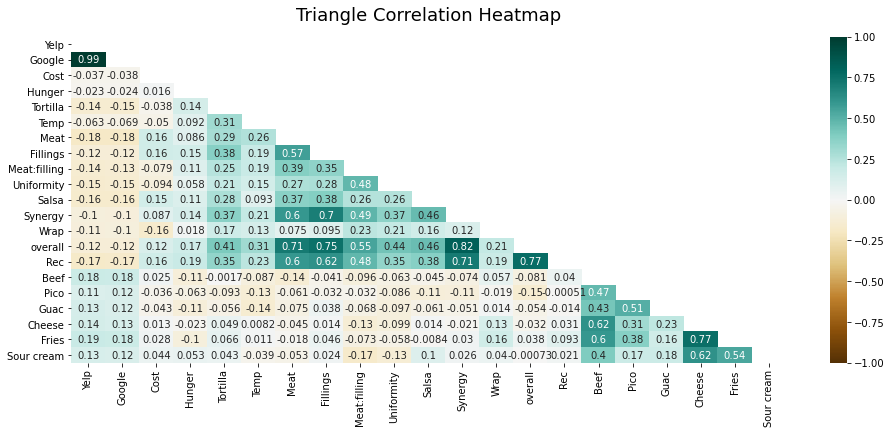

In [71]:
# Correlation
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(df2.corr(), dtype=np.bool))
heatmap = sns.heatmap(df2.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Triangle Correlation Heatmap", fontdict={"fontsize":18}, pad=16);

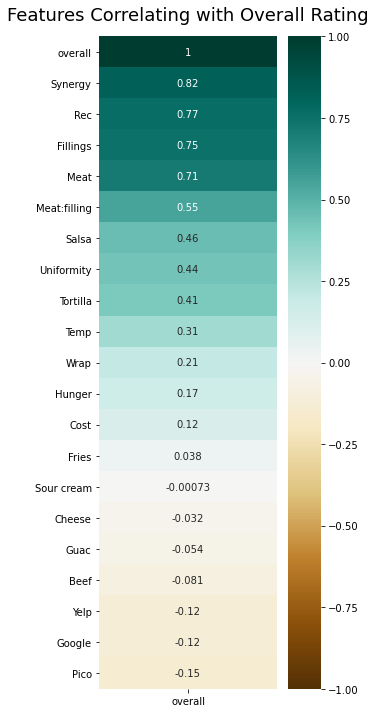

In [72]:
# Overall rating - correlation
plt.figure(figsize=(4, 12))
heatmap = sns.heatmap(df2.corr()[["overall"]].sort_values(by="overall", ascending=False), vmin=-1, vmax=1, annot=True, cmap="BrBG")
heatmap.set_title("Features Correlating with Overall Rating", fontdict={"fontsize":18}, pad=16);

### 2.4 Sentiment Analysis

In [73]:
# Create a new df for notes
df2_notes = df2.filter(["Notes"],axis=1)
df2_notes = df2_notes.dropna(axis=0)
df2_notes

,Notes
0,good fries: 4/5
1,Fries: 3/5; too little meat
3,Go to average burrito place like Rigoberto's i...
6,not fries. big potatoes
8,this tasted really bad leftover. not included ...
...,...
316,Salsa much better this time than before
331,red-orange salsa has a slight fruity flavor th...
332,Rice was plain. Also don't like rice in burrito
351,too many fries. Not great


In [74]:
# calculate word count
df2_notes["word_count"] = df2_notes["Notes"].apply(lambda x: len(str(x).split(" ")))

In [75]:
# calculate character
df2_notes["char_count"] = df2_notes["Notes"].str.len()
df2_notes

,Notes,word_count,char_count
0,good fries: 4/5,3,15
1,Fries: 3/5; too little meat,5,27
3,Go to average burrito place like Rigoberto's i...,12,74
6,not fries. big potatoes,4,23
8,this tasted really bad leftover. not included ...,9,55
...,...,...,...
316,Salsa much better this time than before,7,39
331,red-orange salsa has a slight fruity flavor th...,10,62
332,Rice was plain. Also don't like rice in burrito,9,47
351,too many fries. Not great,5,25


In [76]:
# Calculate average words
def avg_word(notes):
  words = notes.split()
  return (sum(len(word) for word in words) / len(words))

df2_notes["avg_word"] = df2_notes["Notes"].apply(lambda x: avg_word(x))

In [77]:
stop_words = stopwords.words("english")
df2_notes["stopword_coun"] = df2_notes["Notes"].apply(lambda x: len([x for x in x.split() if x in stop_words]))

In [78]:
df2_notes.head()

,Notes,word_count,char_count,avg_word,stopword_coun
0,good fries: 4/5,3,15,4.333333,0
1,Fries: 3/5; too little meat,5,27,4.600000,1
3,Go to average burrito place like Rigoberto's i...,12,74,5.250000,2
6,not fries. big potatoes,4,23,5.000000,1
8,this tasted really bad leftover. not included ...,9,55,5.222222,3


In [79]:
# Lower case all words
df2_notes["review_lower"] = df2_notes["Notes"].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [80]:
# Remove Punctuation
df2_notes["review_nopunc"] = df2_notes["Notes"].str.replace('[^\w\s]', '')

In [81]:
# Remove Stopwords
df2_notes["review_nopunc_nostop"] = df2_notes["review_nopunc"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [82]:
# Return frequency of values
freq= pd.Series(" ".join(df2_notes["review_nopunc_nostop"]).split()).value_counts()[:30]

In [83]:
other_stopwords = ['get', 'us', 'see', 'use', 'said', 'asked', 'day', 'go' \
  'even', 'ive', 'right', 'left', 'always', 'would', 'told', \
  'get', 'us', 'would', 'get', 'one', 'ive', 'go', 'even', \
  'also', 'ever', 'x', 'take', 'let' ]
df2_notes["review_nopunc_nostop_nocommon"] = df2_notes["review_nopunc_nostop"].apply(lambda x: "".join(" ".join(x for x in x.split() if x not in other_stopwords)))

In [84]:
# Lemmatize final review format
df2_notes["cleaned_review"] = df2_notes["review_nopunc_nostop_nocommon"]\
.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [85]:
# Calculate polarity
df2_notes["polarity"] = df2_notes["cleaned_review"].apply(lambda x: TextBlob(x).sentiment[0])
df2_notes[["cleaned_review", "polarity"]]

,cleaned_review,polarity
0,good fry 45,0.700000
1,Fries 35 little meat,-0.187500
3,Go average burrito place like Rigobertos la jo...,-0.575000
6,fry big potato,0.000000
8,tasted really bad leftover included rating,-0.700000
...,...,...
316,Salsa much better time,0.500000
331,redorange salsa slight fruity flavor thats rea...,0.266667
332,Rice plain Also dont like rice burrito,-0.214286
351,many fry Not great,0.050000


In [86]:
# Calculate subjectivity
df2_notes["subjectivity"] = df2_notes["cleaned_review"].apply(lambda x: TextBlob(x).sentiment[1])
df2_notes_clean = df2_notes[["cleaned_review", "polarity", "subjectivity"]]

In [87]:
df2_notes_clean["polarity"].astype(float)
df2_notes_clean.describe()

,polarity,subjectivity
count,128.000000,128.000000
mean,0.179101,0.438981
std,0.362267,0.259991
min,-1.000000,0.000000
25%,0.000000,0.291071
50%,0.124479,0.500000
75%,0.461607,0.600000
max,1.000000,1.000000


In [88]:
# Filter positive comments
df2_notes_clean_posi = df2_notes_clean[df2_notes_clean["polarity"] > 0.5]
df2_notes_clean_posi.sort_values(by = "polarity", ascending = False)

,cleaned_review,polarity,subjectivity
303,Fresca verde salsa best,1.000000,0.300000
257,best breakfast burrito Ive,1.000000,0.300000
246,Best horchata Fries great Chips really good,0.833333,0.550000
77,A wonderful eating experience best California ...,0.700000,0.766667
189,guac good avocadoy,0.700000,0.600000
240,Carnitas good,0.700000,0.600000
239,Good tortilla good amount food needed guac sal...,0.700000,0.600000
238,tamale isnt good,0.700000,0.600000
233,Tortilla burnt bit good Pick good,0.700000,0.600000
200,Good guac,0.700000,0.600000


In [89]:
# Count most frequent words - positive
df2_notes_clean_posi["cleaned_review"] = df2_notes_clean_posi["cleaned_review"].str.lower()
comment = []
for i in range(len(df2_notes_clean_posi)):
    split_word = df2_notes_clean_posi["cleaned_review"].iloc[i].split(" ")
    for word in split_word:
        comment.append(word)

dic_posi = {}
for word in comment:
    if word not in dic_posi:
        dic_posi[word] = 1
    else:
        dic_posi[word] = dic_posi[word] + 1


sorted(dic_posi.items(), key=lambda x: x[1], reverse=True)


<ipython-input-89-a1717d0e8393>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_notes_clean_posi["cleaned_review"] = df2_notes_clean_posi["cleaned_review"].str.lower()


[('good', 25),
 ('really', 6),
 ('best', 5),
 ('guac', 5),
 ('burrito', 4),
 ('fry', 3),
 ('great', 3),
 ('fish', 3),
 ('horchata', 3),
 ('fries', 2),
 ('ive', 2),
 ('crunch', 2),
 ('super', 2),
 ('amount', 2),
 ('chip', 2),
 ('tortilla', 2),
 ('bit', 2),
 ('salsa', 2),
 ('chips', 2),
 ('45', 1),
 ('beans', 1),
 ('surprisingly', 1),
 ('cheese', 1),
 ('melted', 1),
 ('potato', 1),
 ('a', 1),
 ('wonderful', 1),
 ('eating', 1),
 ('experience', 1),
 ('california', 1),
 ('far', 1),
 ('pineapple', 1),
 ('not', 1),
 ('fishy', 1),
 ('cabbage', 1),
 ('fried', 1),
 ('generous', 1),
 ('given', 1),
 ('free', 1),
 ('novel', 1),
 ('lotus', 1),
 ('add', 1),
 ('taste', 1),
 ('homemade', 1),
 ('thats', 1),
 ('thing', 1),
 ('avocadoy', 1),
 ('lime', 1),
 ('could', 1),
 ('better', 1),
 ('burnt', 1),
 ('pick', 1),
 ('alfajores', 1),
 ('dessert', 1),
 ('cheap', 1),
 ('tamale', 1),
 ('isnt', 1),
 ('food', 1),
 ('needed', 1),
 ('balance', 1),
 ('density', 1),
 ('filling', 1),
 ('carnitas', 1),
 ('little', 1)

In [90]:
# Filter negative comments
df2_notes_clean_nega = df2_notes_clean[df2_notes_clean["polarity"] < -0.5]
df2_notes_clean_nega.sort_values(by = "polarity", ascending = True)

,cleaned_review,polarity,subjectivity
93,Fries terrible Burrito leaked,-1.000,1.000000
8,tasted really bad leftover included rating,-0.700,0.666667
104,Grocery store tortilla cold guac,-0.600,1.000000
3,Go average burrito place like Rigobertos la jo...,-0.575,0.700000


In [91]:
# Count most frequent words - negative
df2_notes_clean_nega["cleaned_review"] = df2_notes_clean_nega["cleaned_review"].str.lower()

comment = []
for i in range(len(df2_notes_clean_nega)):
    split_word = df2_notes_clean_nega["cleaned_review"].iloc[i].split(" ")
    for word in split_word:
        comment.append(word)

dic_nega = {}
for word in comment:
    if word not in dic_nega:
        dic_nega[word] = 1
    else:
        dic_nega[word] = dic_nega[word] + 1


sorted(dic_nega.items(), key=lambda x: x[1], reverse=True)


<ipython-input-91-50dd999bfc35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_notes_clean_nega["cleaned_review"] = df2_notes_clean_nega["cleaned_review"].str.lower()


[('burrito', 2),
 ('terrible', 2),
 ('go', 1),
 ('average', 1),
 ('place', 1),
 ('like', 1),
 ('rigobertos', 1),
 ('la', 1),
 ('jolla', 1),
 ('tamale', 1),
 ('tasted', 1),
 ('really', 1),
 ('bad', 1),
 ('leftover', 1),
 ('included', 1),
 ('rating', 1),
 ('fries', 1),
 ('leaked', 1),
 ('grocery', 1),
 ('store', 1),
 ('tortilla', 1),
 ('cold', 1),
 ('guac', 1)]